# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random

from extrucal.extrusion import throughput_cal

from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import warnings

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor

from sklearn.utils import shuffle

from sklearn.naive_bayes import MultinomialNB

from tqdm import tqdm

random.seed(0)

# Dataset Read In

In [2]:
df = pd.read_csv("../data/extrucal_dataset.csv")
df

,extruder_size,metering_depth,polymer_density,rpm,screw_pitch,flight_width,number_flight,throughput
0,80,7.2,1200,95,48.0,12.0,2,92.55
1,220,17.6,1300,75,154.0,13.2,1,4397.68
2,190,7.6,1400,95,323.0,36.1,2,3187.76
3,190,7.6,800,55,228.0,26.6,1,1008.12
4,60,1.8,800,10,48.0,10.8,1,2.72
...,...,...,...,...,...,...,...,...
1935355,40,3.2,1000,30,32.0,4.0,1,8.78
1935356,180,3.6,800,85,306.0,27.0,2,762.58
1935357,30,1.8,1100,60,30.0,2.7,1,7.89
1935358,70,6.3,1000,40,35.0,10.5,2,11.59


# Useful Functions

In [3]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [4]:
def mape(true, pred):
    return 100.0 * np.mean(np.abs((pred - true) / (true+0.1)))  # 0.1 was added to prevent division by zero

# make a scorer function that we can pass into cross-validation
mape_scorer = make_scorer(mape, greater_is_better=False)

# Train/Test Split

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
train_df.head()

,extruder_size,metering_depth,polymer_density,rpm,screw_pitch,flight_width,number_flight,throughput
665324,120,9.6,1400,50,72.0,24.0,2,93.53
775241,230,9.2,1200,45,161.0,43.7,2,624.11
867365,220,11.0,800,90,242.0,13.2,1,3208.52
1458314,250,10.0,1150,0,300.0,50.0,2,0.00
1097383,70,5.6,800,45,77.0,7.0,2,64.95


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1548288 entries, 665324 to 773630
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   extruder_size    1548288 non-null  int64  
 1   metering_depth   1548288 non-null  float64
 2   polymer_density  1548288 non-null  int64  
 3   rpm              1548288 non-null  int64  
 4   screw_pitch      1548288 non-null  float64
 5   flight_width     1548288 non-null  float64
 6   number_flight    1548288 non-null  int64  
 7   throughput       1548288 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 106.3 MB


In [7]:
X_train = train_df.drop(columns=["throughput"])
y_train = train_df["throughput"]

X_test = test_df.drop(columns=["throughput"])
y_test = test_df["throughput"]

# `RandomForestRegressor`

### 1. Training

In [8]:
random_state = 123

pipe_rf = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=random_state))

In [9]:
%%time

pipe_rf.fit(X_train, y_train)

CPU times: total: 9min 4s
Wall time: 9min 4s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=123))])

### 2. Evaluation

In [10]:
y_pred = pipe_rf.predict(X_test)

In [11]:
mape(y_test, y_pred)

3.619547444270308

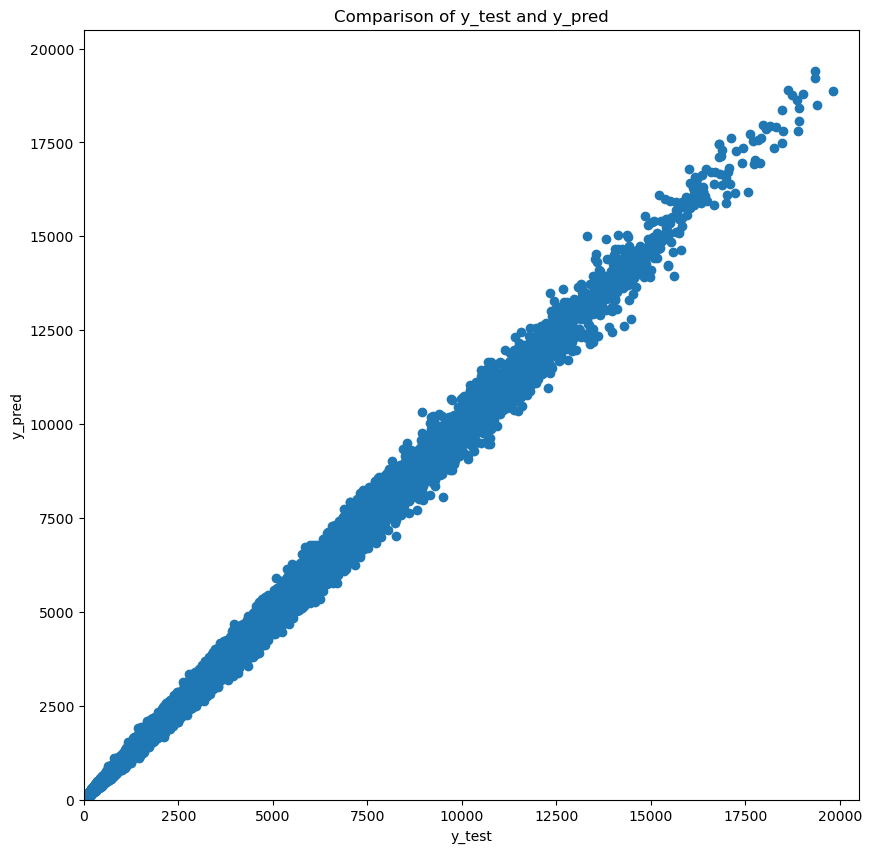

In [12]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.xlim(0, 20500)
plt.ylim(0, 20500)
plt.title("Comparison of y_test and y_pred")
plt.show();

### 3. Comparison with `extrucal` results

In [13]:
extruder_size = []
for i in range(50, 251, 50):
    extruder_size.extend([i]*10)

metering_depth_percent = [0.05] * 50
polymer_density = [1000] * 50
screw_pitch_percent = [1] * 50
flight_width_percent = [0.1] * 50
number_flight = [1] * 50
rpm = [r for r in range(0, 91, 10)] * 5

In [14]:
df = pd.DataFrame(
    {"extruder_size": extruder_size,
     "metering_depth_percent": metering_depth_percent,
     "polymer_density": polymer_density,
     "screw_pitch_percent": screw_pitch_percent,
     "flight_width_percent": flight_width_percent,
     "number_flight": number_flight,
     "rpm": rpm}
)

df["metering_depth"] = df["extruder_size"] * df["metering_depth_percent"]
df["screw_pitch"] = df["extruder_size"] * df["screw_pitch_percent"]
df["flight_width"] = df["extruder_size"] * df["flight_width_percent"]

new_col_order = [
    "extruder_size", "metering_depth", "polymer_density", 
    "rpm", "screw_pitch", "flight_width", "number_flight", ]

df = df[new_col_order]
df.head()

,extruder_size,metering_depth,polymer_density,rpm,screw_pitch,flight_width,number_flight
0,50,2.5,1000,0,50,5.0,1
1,50,2.5,1000,10,50,5.0,1
2,50,2.5,1000,20,50,5.0,1
3,50,2.5,1000,30,50,5.0,1
4,50,2.5,1000,40,50,5.0,1


In [15]:
df["RF_model"] = pipe_rf.predict(df)

In [16]:
df["extrucal"] = df.apply(
    lambda row: throughput_cal(
        row["extruder_size"],
        row["metering_depth"],
        row["polymer_density"],
        row["rpm"],
        row["screw_pitch"],
        row["flight_width"],
        int(row["number_flight"])), axis=1
)

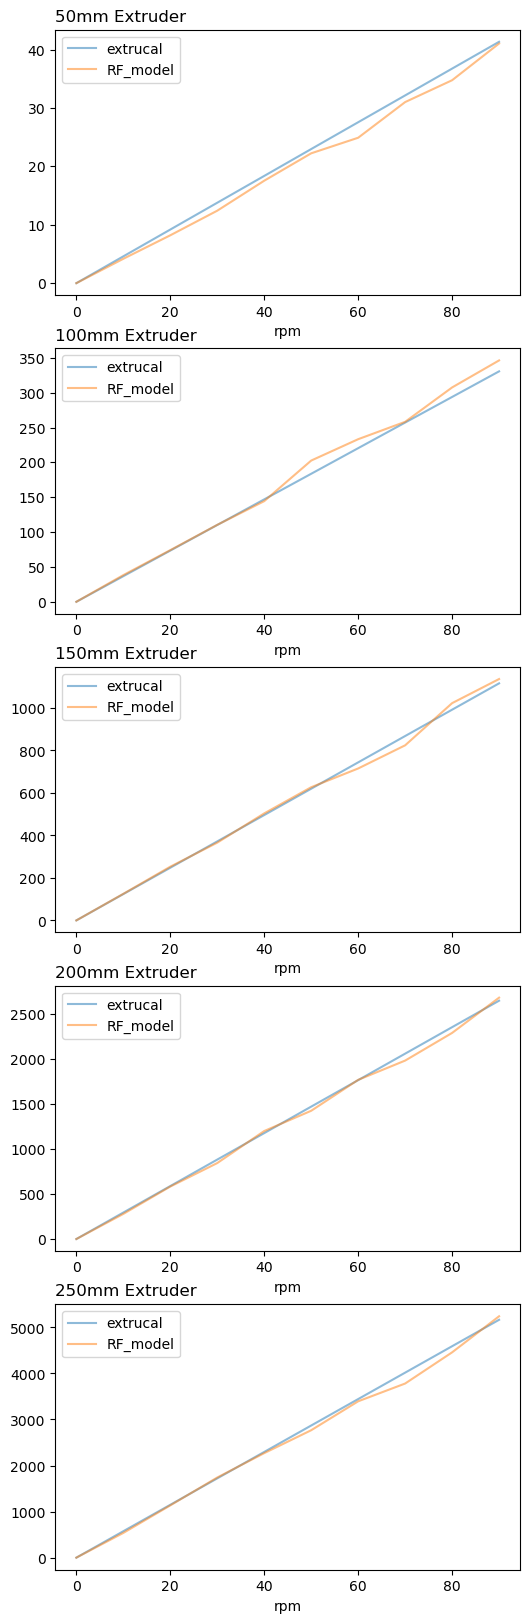

In [17]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(6, 20))

fig = df.loc[0:9, ["rpm", "extrucal", "RF_model"]].plot.line(
    x="rpm", ax=axes[0], alpha=0.5
)
fig.set_title("50mm Extruder", loc='left')
fig = df.loc[10:19, ["rpm", "extrucal", "RF_model"]].plot.line(
    x="rpm", ax=axes[1], alpha=0.5
)
fig.set_title("100mm Extruder", loc='left')
fig = df.loc[20:29, ["rpm", "extrucal", "RF_model"]].plot.line(
    x="rpm", ax=axes[2], alpha=0.5
)
fig.set_title("150mm Extruder", loc='left')
fig = df.loc[30:39, ["rpm", "extrucal", "RF_model"]].plot.line(
    x="rpm", ax=axes[3], alpha=0.5
)
fig.set_title("200mm Extruder", loc='left')
fig = df.loc[40:, ["rpm", "extrucal", "RF_model"]].plot.line(
    x="rpm", ax=axes[4], alpha=0.5
)
fig.set_title("250mm Extruder", loc='left')
plt.show();

In [23]:
# %%time

# import joblib

# joblib.dump(pipe_rf, "rf_model.pkl", compress=3)

CPU times: total: 2min 16s
Wall time: 2min 27s


['rf_model.pkl']

In [ ]:
# joblib without any compression -> 10.8 GB
# joblib with compress=3 -> 2.49 GB (2min 16sec)
# joblib with compress=9 -> 2.25GB (19min 43sec)